In [2]:
# READING USERS DF

import pandas as pd
import numpy as np
import os
os.chdir("c://Users//gufer//OneDrive//Documentos//FIAP//Fase_05//ML_Engineer_Datathon/")

In [3]:
users = pd.read_parquet("data/processed_data/features/users_feats.parquet")
df_users = users

In [4]:
def create_target(df_users: pd.DataFrame) -> pd.DataFrame:
    """Gera a coluna TARGET padronizada de forma menos sensível a outliers (robust scaling)."""
    
    # Agrega usando diferentes estratégias de agrupamento
    agg_df = df_users.groupby('userId', as_index=False).agg({
        'numberOfClicksHistory': 'sum',
        'timeOnPageHistory': 'sum',
        'scrollPercentageHistory': 'mean',
        'pageVisitsCountHistory': 'sum',
        'minutesSinceLastVisit': 'mean'
    })
    
    # Aplica transformação logarítmica para reduzir a influência de outliers
    agg_df['pageVisitsTransformed'] = np.log1p(agg_df['pageVisitsCountHistory'])
    
    # Cálculo do TARGET com pesos ajustados, usando a versão transformada de pageVisitsCountHistory
    agg_df['TARGET'] = (
        agg_df['numberOfClicksHistory'] +
        1.5 * (agg_df['timeOnPageHistory'] / 500) +
        agg_df['scrollPercentageHistory'] +
        2 * agg_df['pageVisitsTransformed'] -
        (agg_df['minutesSinceLastVisit'] / 20)
    )
    
    # Calcula a mediana dos valores de 'TARGET'
    median_val = agg_df['TARGET'].median()

    # Calcula o intervalo interquartil (IQR)
    iqr_val = agg_df['TARGET'].quantile(0.75) - agg_df['TARGET'].quantile(0.25)

    # Se o IQR for zero (todos os valores iguais, por exemplo), apenas subtrai a mediana
    # Caso contrário, padroniza (robust scaling) subtraindo a mediana e dividindo pelo IQR
    if iqr_val == 0:
        agg_df['TARGET'] = agg_df['TARGET'] - median_val
    else:
        agg_df['TARGET'] = (agg_df['TARGET'] - median_val) / iqr_val

    # Mescla os valores padronizados de 'TARGET' de volta ao DataFrame original
    target_df = df_users.merge(agg_df[['userId', 'TARGET']], on='userId', how='left')

    return target_df

target_df = create_target(df_users)
target_df

,userId,userType,historySize,pageId,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,minutesSinceLastVisit,timestampHistoryDate,timestampHistoryTime,timestampHistoryWeekday,timestampHistoryHour,isWeekend,dayPeriod,coldStart,TARGET
0,00011b1ced626112372206634e0e9b5ccb432da916e83f...,Non-Logged,1,c9b148e7-72fa-416e-84ac-a4499abc7aaf,0,14071,23.46,1,0.0,2022-07-26,14:10:06,1,14,False,afternoon,True,-0.190421
1,00012cd490cea9fe043146807def18c830fa0d0b791772...,Non-Logged,3,5a5e2555-ac88-4882-9dc2-e19bb392a448,0,50000,56.08,1,0.0,2022-07-31,19:44:24,6,19,True,night,True,0.166289
2,00012cd490cea9fe043146807def18c830fa0d0b791772...,Non-Logged,3,3363b054-df39-4e3d-b2b3-dd3cb227dd55,0,52647,59.64,1,1.0,2022-07-31,19:45:52,6,19,True,night,True,0.166289
3,00012cd490cea9fe043146807def18c830fa0d0b791772...,Non-Logged,3,e81de120-5005-4a01-8b63-90018005903e,0,60000,42.28,1,34.0,2022-07-31,20:19:50,6,20,True,night,True,0.166289
4,00024d84a3d619b1972e9dd5efa9c930557d85f6463fd6...,Logged,1,c274ed4b-e679-41ce-9dfb-c53874916511,11,32436,46.58,1,0.0,2022-07-30,18:58:05,5,18,True,night,True,-0.123527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808073,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,fb5459eb-d86b-447e-83d5-0172fbab1ecd,0,10000,39.53,1,13.0,2022-08-06,01:28:47,5,1,True,dawn,False,3.668507
808074,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,2e3300c6-3a18-4908-b9a9-a955cfcdcfcc,0,50000,34.46,2,5716.0,2022-08-10,00:44:20,2,0,False,dawn,False,3.668507
808075,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,1ca0b64a-8bb4-4a2b-b3d0-af935960bf15,0,10000,7.05,1,619.0,2022-08-10,11:03:12,2,11,False,morning,False,3.668507
808076,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,Non-Logged,26,331bc28e-4e05-425e-8914-766606dfdf88,0,50000,21.99,1,1178.0,2022-08-11,06:40:54,3,6,False,morning,False,3.668507


In [5]:
# Target: ENGAGEMENT_SCORE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_target_distribution(df):
    """Plota a distribuição da variável TARGET."""
    plt.figure(figsize=(10, 5))
    sns.histplot(df['TARGET'], bins=50, kde=True)
    plt.xlabel('TARGET (Engajamento Padronizado)')
    plt.ylabel('Frequência')
    plt.title('Distribuição da Variável TARGET')
    plt.grid(True)
    plt.show()

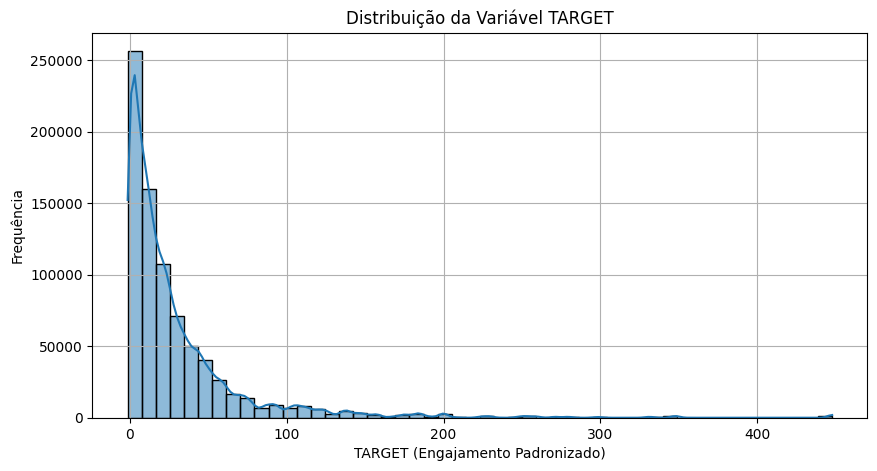

In [6]:
plot_target_distribution(target_df)

In [7]:
TARGET_INIT_COLS = [
    "userId", 
    "pageId",
    "numberOfClicksHistory",
    "timeOnPageHistory",
    "coldStart",
    "scrollPercentageHistory",
    "minutesSinceLastVisit",
    "timeGapDays"
]

TARGET_FINAL_COLS = [
    "userId", 
    "pageId",
    "TARGET"
]

In [8]:
def preprocess_target(
    df_users: pd.DataFrame,
    gap_df: pd.DataFrame
) -> pd.DataFrame:
    """Gera a coluna TARGET para medir engajamento por usuário/página, considerando o gap de tempo"""
    
    # Mescla os DataFrames com base em userId e pageId
    target_df = df_users.merge(gap_df, on=["userId", "pageId"])[TARGET_INIT_COLS]
    
    # Calcula um score base de engajamento usando as métricas históricas do usuário
    base_score = (
        target_df['numberOfClicksHistory']
        + (target_df['timeOnPageHistory'] / 500)
        + target_df['scrollPercentageHistory']
        - (target_df['minutesSinceLastVisit'] / 50)
    )
    
    # Fator multiplicativo que penaliza usuários que demoram muito para ver notícias (menos engajados)
    gap_factor = 1 / (1 + target_df['timeGapDays'])
    
    # Calcula o TARGET combinando o score base com o fator de gap
    target_df['TARGET'] = base_score * gap_factor
    
    # Padroniza TARGET utilizando robust scaling (subtrai a mediana e divide pelo IQR)
    median_val = target_df['TARGET'].median()
    iqr_val = target_df['TARGET'].quantile(0.75) - target_df['TARGET'].quantile(0.25)
    
    if iqr_val == 0:
        target_df['TARGET'] = target_df['TARGET'] - median_val
    else:
        target_df['TARGET'] = (target_df['TARGET'] - median_val) / iqr_val
    
    # Mantém só as colunas essenciais do dataframe de target
    target_df = target_df[TARGET_FINAL_COLS]
    
    return target_df

gap = pd.read_parquet("data/processed_data/features/gap_feats.parquet")

target_new = preprocess_target(df_users, gap)
target_new

,userId,pageId,TARGET
0,0006ea19bc2de7e755b09f3a5a8f8d677f0860e4b8f64e...,fc1d78dd-8bcd-4b58-8564-078c024e9a28,-0.136035
1,0007faff9dc5595d8bc98d13619c483c8ed73d5bf93822...,2775a8d1-78bc-4ad7-89bd-b5b6131e0ffe,0.188879
2,001a6375507d3128ddbdca3038952e943aa740a4013fa7...,26135428-2804-4db4-aef5-f9fcf756b0a4,0.070399
3,001a6375507d3128ddbdca3038952e943aa740a4013fa7...,eb5879d5-af89-46dd-b06c-2df5a0d60af3,-0.305744
4,001a6375507d3128ddbdca3038952e943aa740a4013fa7...,e0b8e742-f94f-4361-b662-9e9d24c99803,9.573205
...,...,...,...
44902,ffe712e6ed65e6957dd8cc4d9bd99852fcdc2a652312ea...,79acc216-7fa2-44d7-94c2-04df106d45e7,-0.309010
44903,fff3ab996fd24e7ea351fcec4f4dd18cd159684a8d3ae8...,dec897ab-ba10-4083-903d-de674ea6cfbe,0.262307
44904,fff8b83a17df3c162182b2f4a4ed6093f446fc869e0e2d...,d7b34225-e694-4564-9825-833e76ca13d0,-0.217590
44905,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,a1344ecc-8aff-42ad-abfc-08b84462e545,-0.306677


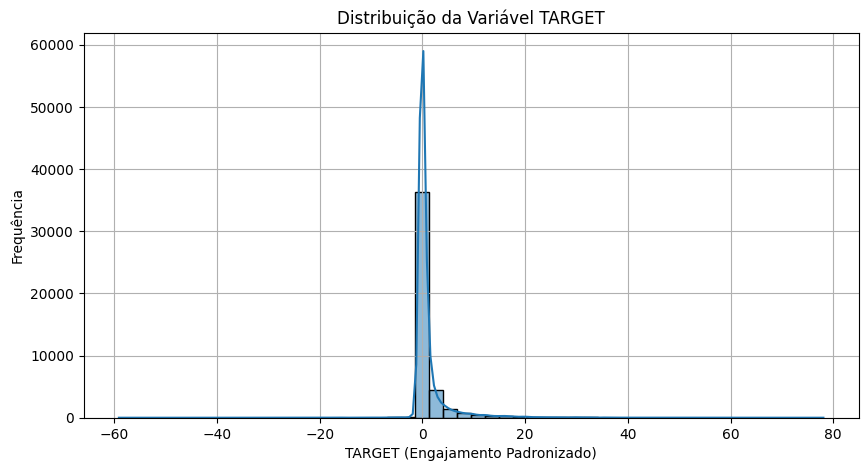

In [9]:
plot_target_distribution(target_new)

In [10]:
final_feats_with_target = pd.read_parquet("data/processed_data/features/final_feats_with_target.parquet")

In [11]:
final_feats_with_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230356 entries, 0 to 2230355
Data columns (total 19 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   userId                    object        
 1   pageId                    object        
 2   userType                  category      
 3   issuedDatetime            datetime64[ns]
 4   timestampHistoryDatetime  datetime64[ns]
 5   coldStart                 bool          
 6   localState                object        
 7   localRegion               object        
 8   themeMain                 object        
 9   themeSub                  object        
 10  countLocalStateUser       float64       
 11  relLocalState             float64       
 12  countLocalRegionUser      float64       
 13  relLocalRegion            float64       
 14  countThemeMainUser        float64       
 15  relThemeMain              float64       
 16  countThemeSubUser         float64       
 17  relTheme

In [12]:
gap_df = pd.read_parquet("data/processed_data/features/gap_feats.parquet")

In [13]:
TARGET_INIT_COLS = [
    "userId", 
    "pageId",
    "historySize",
    "numberOfClicksHistory",
    "timeOnPageHistory",
    "scrollPercentageHistory",
    "minutesSinceLastVisit",
    "timeGapDays",
]

# Mescla os DataFrames com base em userId e pageId
target_df = df_users.merge(gap_df, on=["userId", "pageId"])[TARGET_INIT_COLS]
target_df.describe()

,historySize,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,minutesSinceLastVisit,timeGapDays
count,44907.000000,44907.000000,4.490700e+04,44907.000000,44907.000000,44907.000000
mean,130.403857,10.906607,8.470125e+04,43.497385,1459.113525,159.386955
std,210.730677,25.465378,9.352409e+04,23.066448,4455.452148,388.341905
min,1.000000,0.000000,5.011000e+03,1.050000,0.000000,0.000000
25%,17.000000,0.000000,2.671650e+04,25.390000,2.000000,8.000000
50%,67.000000,1.000000,5.723200e+04,42.270000,40.000000,23.000000
75%,158.000000,12.000000,1.100000e+05,59.450000,1002.500000,41.000000
max,2051.000000,1229.000000,2.206163e+06,102.430000,60120.000000,2404.000000


In [14]:
X_train = pd.read_parquet("data/processed_data/train/X_train.parquet")
y_train = pd.read_parquet("data/processed_data/train/y_train.parquet")
X_train.columns

Index(['userType', 'coldStart', 'localState', 'localRegion', 'themeMain',
       'themeSub', 'relLocalRegion', 'relThemeMain', 'relThemeSub'],
      dtype='object')

In [15]:
def feature_selection(
    suggested_feats, 
    df_target, 
    target_col='TARGET', 
    method="correlation", 
    drop_cols=None, 
    threshold=0.95, 
    k_best=10):
    """
    Realiza a seleção de features no dataframe suggested_feats.

    Parâmetros:
        suggested_feats (DataFrame): DataFrame com as features finais.
        df_target (DataFrame): DataFrame contendo o target.
        target_col (str): String com a coluna alvo de engajamento (variável dependente).
        method (str): Método de seleção. Pode ser:
                      - "correlation": remove features altamente correlacionadas.
                      - "univariate": seleciona as k melhores features via teste univariado (ANOVA).
        drop_cols (list): Lista de colunas a serem descartadas antes da seleção (ex.: identificadores).
        threshold (float): Limite de correlação para remoção de features redundantes (método "correlation").
        k_best (int): Número de melhores features a serem selecionadas (método "univariate").

    Retorna:
        DataFrame: DataFrame com as features selecionadas e a coluna target_col.
    """
    COR_COLS = [
        'localState', 'localRegion', 'themeMain', 'themeSub',
        'countLocalStateUser', 'relLocalState', 'countLocalRegionUser',
        'relLocalRegion', 'countThemeMainUser', 'relThemeMain',
        'countThemeSubUser', 'relThemeSub'
    ]
    # Remove as colunas que não são consideradas para o processo de seleção
    if drop_cols is not None:
        df = df.drop(columns=drop_cols)
    
    # Separa as variáveis preditoras (X) e a variável alvo (y)
    X = suggested_feats[COR_COLS]
    y = df_target
    
    if method == "correlation":
        # Calcula a matriz de correlação entre as features
        corr_matrix = X.corr().abs()
        # Considera apenas a parte superior da matriz para evitar redundância
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # Identifica features que possuem alta correlação com alguma outra feature
        drop_features = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]
        X_selected = X.drop(columns=drop_features)
        print(f"Features removidas por alta correlação: {drop_features}")
        return pd.concat([X_selected, y], axis=1)
    
    elif method == "univariate":
        # Seleção univariada utilizando o teste F (ANOVA) para regressão/classificação
        selector = SelectKBest(score_func=f_classif, k=k_best)
        selector.fit(X, y)
        mask = selector.get_support()  # Máscara booleana das features selecionadas
        selected_features = X.columns[mask]
        print(f"Features selecionadas pelo método univariado: {list(selected_features)}")
        X_selected = X[selected_features]
        return pd.concat([X_selected, y], axis=1)
    
    else:
        raise ValueError("Método de seleção desconhecido. Escolha 'correlation' ou 'univariate'.")

In [16]:
X_train.describe()

,userType,localState,localRegion,themeMain,themeSub,relLocalRegion,relThemeMain,relThemeSub
count,1.561249e+06,1.526798e+06,1.526798e+06,687080.000000,611273.000000,1.526798e+06,687080.000000,611273.000000
mean,7.671187e-01,2.300704e-01,2.044492e-01,0.493478,0.601411,5.873608e-01,0.083394,0.070894
std,2.494133e-01,1.674994e-01,1.859404e-01,0.263304,0.266730,2.284556e-01,0.137972,0.111236
min,1.345423e-01,1.624314e-04,1.309931e-06,0.000001,0.000002,4.444444e-03,0.004444,0.004444
25%,8.654577e-01,7.223680e-02,2.951144e-02,0.197223,0.752798,5.454545e-01,0.054054,0.054054
50%,8.654577e-01,1.655772e-01,1.253610e-01,0.673248,0.752798,7.027027e-01,0.054054,0.054054
75%,8.654577e-01,4.196475e-01,4.196475e-01,0.673248,0.752798,7.027027e-01,0.054054,0.054054
max,8.654577e-01,4.196475e-01,4.196475e-01,0.673248,0.752798,1.000000e+00,1.000000,1.000000


In [29]:
feature_selection(X_train, y_train)

Features removidas por alta correlação: ['localRegion', 'themeSub']


,localState,themeMain,countLocalStateUser,relLocalState,countLocalRegionUser,relLocalRegion,countThemeMainUser,relThemeMain,countThemeSubUser,relThemeSub,TARGET
252081,0.165577,NaN,35.0,0.155556,5.0,0.022222,NaN,NaN,NaN,NaN,3.860478
1387706,0.125361,NaN,57.0,0.721519,57.0,0.721519,NaN,NaN,NaN,NaN,0.108736
2113593,0.125361,NaN,55.0,0.753425,55.0,0.753425,NaN,NaN,NaN,NaN,1.721917
165983,0.047471,NaN,55.0,0.597826,55.0,0.597826,NaN,NaN,NaN,NaN,2.110034
832021,0.419648,NaN,78.0,0.702703,78.0,0.702703,NaN,NaN,NaN,NaN,0.125647
...,...,...,...,...,...,...,...,...,...,...,...
732180,0.419648,0.673248,78.0,0.702703,78.0,0.702703,6.0,0.054054,6.0,0.054054,25.220086
110268,0.047471,NaN,55.0,0.597826,55.0,0.597826,NaN,NaN,NaN,NaN,2.785324
1692743,0.029511,NaN,19.0,0.791667,19.0,0.791667,NaN,NaN,NaN,NaN,-0.035535
2229084,0.072237,NaN,1.0,0.066667,1.0,0.066667,NaN,NaN,NaN,NaN,2.214242


In [21]:
y_train

,TARGET
252081,3.860478
1387706,0.108736
2113593,1.721917
165983,2.110034
832021,0.125647
...,...
732180,25.220086
110268,2.785324
1692743,-0.035535
2229084,2.214242


In [14]:
X_train

,userType,issuedDatetime,timestampHistoryDatetime,coldStart,localState,localRegion,themeMain,themeSub,countLocalStateUser,relLocalState,countLocalRegionUser,relLocalRegion,countThemeMainUser,relThemeMain,countThemeSubUser,relThemeSub
252081,0.865458,2022-07-15 18:47:28,2022-07-28 23:24:04,False,0.165577,0.021661,NaN,NaN,35.0,0.155556,5.0,0.022222,NaN,NaN,NaN,NaN
1387706,0.865458,2021-11-04 16:20:13,2022-07-14 14:26:06,False,0.125361,0.125361,NaN,NaN,57.0,0.721519,57.0,0.721519,NaN,NaN,NaN,NaN
2113593,0.865458,2022-07-12 11:31:48,2022-08-04 19:50:44,False,0.125361,0.125361,NaN,NaN,55.0,0.753425,55.0,0.753425,NaN,NaN,NaN,NaN
165983,0.865458,2022-07-08 11:51:02,2022-08-09 17:54:45,False,0.047471,0.047471,NaN,NaN,55.0,0.597826,55.0,0.597826,NaN,NaN,NaN,NaN
832021,0.865458,2021-07-27 19:43:19,2022-07-25 14:29:23,False,0.419648,0.419648,NaN,NaN,78.0,0.702703,78.0,0.702703,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732180,0.865458,2022-07-12 17:30:56,2022-07-21 14:54:19,False,0.419648,0.419648,0.673248,0.752798,78.0,0.702703,78.0,0.702703,6.0,0.054054,6.0,0.054054
110268,0.865458,2022-04-20 14:18:02,2022-07-12 23:05:41,False,0.047471,0.047471,NaN,NaN,55.0,0.597826,55.0,0.597826,NaN,NaN,NaN,NaN
1692743,0.865458,2022-07-26 16:53:25,2022-07-26 18:47:34,False,0.029511,0.029511,NaN,NaN,19.0,0.791667,19.0,0.791667,NaN,NaN,NaN,NaN
2229084,0.134542,2022-07-17 10:27:06,2022-07-24 10:03:57,False,0.072237,0.004236,NaN,NaN,1.0,0.066667,1.0,0.066667,NaN,NaN,NaN,NaN


In [15]:
encoder_mapping = pd.read_parquet("data/processed_data/train/encoder_mapping.parquet")
encoder_mapping.tail(100)

,userType,localState,localRegion,themeMain,themeSub
a-vida-e-pra-ja,NaN,NaN,NaN,NaN,0.000010
variola-dos-macacos,NaN,NaN,NaN,NaN,0.000010
em-movimento,NaN,NaN,NaN,NaN,0.000010
metronorte,NaN,NaN,NaN,NaN,0.000008
sebrae-ms,NaN,NaN,NaN,NaN,0.000008
...,...,...,...,...,...
algar-90-anos,NaN,NaN,NaN,NaN,0.000002
le-biscuit,NaN,NaN,NaN,NaN,0.000002
albert-sabin-hospital-e-maternidade-de-atibaia,NaN,NaN,NaN,NaN,0.000002
colegio-atrio,NaN,NaN,NaN,NaN,0.000002
